# Summary

The `RepoHealth` notebook reviews descriptive statistics and finds patterns which seem to be
shared by healthy and unhealthy repositories. This `PredictingRepoHealth` notebook focuses
solely on predicting time series. 

$v(t) = \alpha + \beta_1 x_1 + \epsilon$

In [1]:
ls ~/code/*.parquet

/Users/tylerbrown/code/author_2019-04-20_0.parquet
/Users/tylerbrown/code/commit_file_2019-04-20_0.parquet
/Users/tylerbrown/code/commit_file_2019-04-20_1.parquet
/Users/tylerbrown/code/contrib_2019-04-20_0.parquet
/Users/tylerbrown/code/df_features_20190424.parquet
/Users/tylerbrown/code/df_target_20190424.parquet
/Users/tylerbrown/code/features_apache__LOGDF__attic-lucy.parquet
/Users/tylerbrown/code/features_apache__LOGDF__attic-wink.parquet
/Users/tylerbrown/code/features_apache__LOGDF__lucene-solr.parquet
/Users/tylerbrown/code/features_apache__LOGDF__spark.parquet
/Users/tylerbrown/code/features_docker__LOGDF__docker-ce.parquet
/Users/tylerbrown/code/features_torvalds__LOGDF__linux.parquet
/Users/tylerbrown/code/info_2019-04-20_0.parquet
/Users/tylerbrown/code/meta_2019-04-20_0.parquet
/Users/tylerbrown/code/target_apache__LOGDF__attic-lucy.parquet
/Users/tylerbrown/code/target_apache__LOGDF__attic-wink.parquet
/Users/tylerbrown/code/target_apache__LOGDF__lucene-solr.parquet
/Use

## Dependencies



In [2]:
from collections import defaultdict
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

## Load Data

Databases have been consolidated and switched to Parquet files with
no more than 2e6 records in each.

In [3]:
commits = pd.read_parquet('/Users/tylerbrown/code/commit_file_2019-04-20_0.parquet', 'pyarrow').append(
    pd.read_parquet('/Users/tylerbrown/code/commit_file_2019-04-20_1.parquet', 'pyarrow')
)
commits.shape

(2327964, 5)

In [4]:
meta = pd.read_parquet('/Users/tylerbrown/code/meta_2019-04-20_0.parquet', 'pyarrow')
meta.shape

(928779, 3)

In [5]:
author = pd.read_parquet('/Users/tylerbrown/code/author_2019-04-20_0.parquet')
author.shape

(928779, 4)

## Helper functions

Use these later in a Python script

In [6]:
def acceleration(v):
    """ Convert velocity vector to acceleration """
    v1 = [v[i] - v[i-1] if i > 0 else v[i] for i in range(v.shape[0])]
    return v1

def acceleration_per_repo(df, period):
   
    cols = ['authored','owner_name', 'project_name', 
            'lines_added', 'lines_subtracted']
    
    per = df.authored.dt.to_period(period)
    grp = [per,'owner_name', 'project_name']
    
    dfgrp = df[cols].groupby(grp).sum()
    dfgrp['velocity'] = dfgrp.lines_added - dfgrp.lines_subtracted
    dfgrp = dfgrp.reset_index()
    
    igrp = ['owner_name', 'project_name']
    dfgrp['acceleration'] = 0.0
    for i, row in dfgrp[igrp].groupby(igrp).count().reset_index().iterrows():
        
        subdf = dfgrp[(dfgrp.owner_name == row.owner_name) & (dfgrp.project_name == row.project_name)]
        v = subdf.velocity.values
        acc = acceleration(v)
        dfgrp.loc[(dfgrp.owner_name == row.owner_name) & 
           (dfgrp.project_name == row.project_name), 'acceleration'] = acc
        
    return dfgrp

# Data Preprocessing

We need to set up a time series.

In [7]:
# Create working table

df = pd.merge(pd.merge(meta, commits), author)
df.shape

(2327964, 10)

In [8]:
print("Weird things didn't happen: {}".format(df.shape[0] == commits.shape[0]))

Weird things didn't happen: True


In [9]:
df['ts'] = pd.to_datetime(df.authored)

## Feature Engineering

We need to create some features to predict velocity.

In [10]:
df.columns

Index(['commit_hash', 'owner_name', 'project_name', 'file_id', 'modified_file',
       'lines_added', 'lines_subtracted', 'name', 'email', 'authored', 'ts'],
      dtype='object')

In [11]:
def num_authors(df, period: str):
    """ Number of authors in a given time period. """
    per = df.ts.dt.to_period(period)
    
    cols = ['name','owner_name', 'project_name']
    grp = [per, 'owner_name', 'project_name']
    result = df[cols].groupby(grp).count()
    result.columns = ['num_authors']
    return result

In [12]:
def num_mentors(df, period:str, subperiod:str, k:int):
    """ 
    Number of authors in a larger time period who have also
    made commits in k number of smaller time periods. 
    
    For example, number of authors in a year who have also 
    committed changes in each month of that year.
    """
    subper = df.ts.dt.to_period(subperiod)
    subcols = ['owner_name', 'project_name',
               'name', 'email']
    subgrp = [subper, 'owner_name', 'project_name', 'name', 'email']
    ok = df[subcols].groupby(subgrp).count()
    ok = ok.reset_index()
    
    if period == 'Y':
        
        ok['year'] = ok.ts.apply(lambda x: x.year)
        cols = ['year', 'owner_name', 'project_name', 'name', 'email']
        grp = ['year','owner_name','project_name', 'name']
        ok = ok[cols].groupby(grp).count()
        
        ok = ok.reset_index()
        ok = ok[['year', 'owner_name', 'project_name', 'email']]
        ok.columns = ['ts', 'owner_name', 'project_name', 'mentor_count']
        result = ok[ok.mentor_count >= k].groupby(['ts', 'owner_name', 'project_name']).count()
        
        result = result.reset_index()
        return result
        
    else:
        raise Exception("Period '{}' not found".format(period))
    
    return df


In [13]:
def num_orgs(df, period):
    """ Number of organizations contributing per time period """
    email_suffix = ['com','org','ru','edu','dk','id.au','ac',
                'de','uk','cz','fr','jp','il','me','net',
                'eu', 'pw', 'ch','cn','io','nu','it','ai',
               'fi', 'info', 'sk', 'ie', 'ca', 'at', 'pl',
               'hu', 'nl', 'works', 'hr', 'se','no', 'blue',
               '(none)', 'lt', 'cc', 'si', 'la', 'us', 'gr',
               'De','br', 'ro', 'li', 'gov', 'pt', 'is', 'sg',
               'vin', 'in', 'be', 'bzh', 'pm', 'xyz', 'fun',
               'es', 'systems', 'cx', 'tw','cl', 'lv', 'ne',
               'co', 'st', 'ma', 'ws', 'su', 'ORG', 'tk', 'cu',
               'COM', 'kr', 'vpc', 'ip', 'danix', 'Com', 're',
               'EDU']
    pattern = '[A-Za-z\-\._0-9\+]+@(.*)?.({})'.format('|'.join(email_suffix))
    pat = re.compile(pattern)
    
    df['org_name'] = df.email.apply(lambda x: pat.match(x).group(1) if pat.match(x) else np.NaN)
    
    per = df.ts.dt.to_period(period)
    cols = ['owner_name', 'project_name', 'org_name']

    result = df[cols].groupby([per, 'owner_name', 'project_name']).count()
    result = result.reset_index()
    return result

## Creating a working dataframe

This is the dataframe we can use for our analysis

In [14]:
X_2 = num_mentors(df, 'Y', 'M', 6)
X_2.head()

,ts,owner_name,project_name,mentor_count
0,2002,apache,lucene-solr,4
1,2003,apache,lucene-solr,3
2,2004,apache,lucene-solr,4
3,2005,apache,lucene-solr,5
4,2005,torvalds,linux,170


In [15]:
X_1 = num_authors(df, 'Y').reset_index()
X_2 = num_mentors(df, 'Y', 'M', 6).reset_index()
X_3 = num_orgs(df, 'Y')

print("X_1 {}, X_2 {}, X_3 {}".format(X_1.shape, X_2.shape, X_3.shape))

X_1 (78, 4), X_2 (60, 5), X_3 (78, 4)


In [16]:
X_13 = pd.merge(X_1, X_3)
X_13.ts  = X_13.ts.apply(lambda x: x.year)
X_13.shape[0] == X_1.shape[0]

True

In [17]:
X = X_13.merge(X_2[['ts','owner_name', 'project_name', 'mentor_count']], 
            how='left', on=['ts','owner_name', 'project_name'])
X.shape

(78, 6)

In [18]:
X.dtypes

ts                int64
owner_name       object
project_name     object
num_authors       int64
org_name          int64
mentor_count    float64
dtype: object

## Defining Target vector

We're trying to predict velocity for the next time period.

In [19]:
per = df.ts.dt.to_period('Y')
cols = ['owner_name', 'project_name', 'lines_added', 'lines_subtracted']
grp = [per, 'owner_name', 'project_name']
df_target = df[cols].groupby(grp).sum()

In [20]:
df_target['velocity'] = df_target.lines_added - df_target.lines_subtracted
df_target = df_target.reset_index()

In [21]:
print("Check target and feature dims match: {}".format(df_target.shape[0] == X.shape[0]))

Check target and feature dims match: True


# Create train/val/test splits

We can break this out by year and see how things go

In [22]:
# Train

X_train = X[X.ts == 2015].fillna(0.0)
y_train = df_target[df_target.ts == 2015].velocity

In [23]:
# Test

X_test = X[X.ts == 2016].fillna(0.0)
y_test = df_target[df_target.ts == 2016].velocity

In [24]:
# Val

X_val = X[X.ts == 2017].fillna(0.0)
y_val = df_target[df_target.ts == 2017].velocity

# Checking features 

Before predicting our features, we want to 
check to see if our features are correlated.

In [25]:
cols = ['num_authors', 'org_name', 'mentor_count']
X_train[cols].corr()

,num_authors,org_name,mentor_count
num_authors,1.000000,1.000000,0.994886
org_name,1.000000,1.000000,0.994907
mentor_count,0.994886,0.994907,1.000000


Great, this is what we call an endogeneity problem. Let's 
transform the variables and see if the correlation goes down. I 
think there's a few outliers driving this correlation. Log transform.

In [26]:
X_train_log = (X_train[cols] + 1).apply(np.log)
X_train_log.corr()

,num_authors,org_name,mentor_count
num_authors,1.000000,1.000000,0.904223
org_name,1.000000,1.000000,0.904232
mentor_count,0.904223,0.904232,1.000000


It's a little better but I can't sufficiently resolve multicollinearity. I'll
run the regression with just the `mentor_count`. 

# Prediction

Predicting velocity

In [27]:
reg = LinearRegression()
reg.fit(X_train[cols], y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

$r^2$ for test set

In [28]:
reg.score(X_test[cols], y_test)

0.8291107770270143

In [29]:
reg.coef_

array([ 504.1639287 , -488.19121967, -435.12321283])

In [30]:
reg.intercept_

-4426.599661330634

$r^2$ for validation set

In [31]:
reg.score(X_val[cols], y_val)

0.9253225467308156

Just using a linear regression seems fairly robust to
predicting `velocity`. Let's try just one feature since
we've got multicollinearity.

In [32]:
col = ['mentor_count']

In [33]:
reg = LinearRegression()
reg.fit(X_train[col], y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [34]:
# Test set

reg.score(X_test[col], y_test)

0.8103672820914342

In [35]:
# Validation set

reg.score(X_val[col], y_val)

0.874378621481338

We can see our accuracy drop a bit but not much when 
multicollinearity is removed. Given that test and validation
sets are subsequent years, let's try predicting a subsequent 
year just for fun.

In [36]:
reg.score(X_test[X_test.project_name != 'attic-wink'][col], y_val)

0.8726493989475013

Looks like we're just as competitive predicting on subsequent years. I think
this is probably sufficient for scaling up to Spark tomorrow.

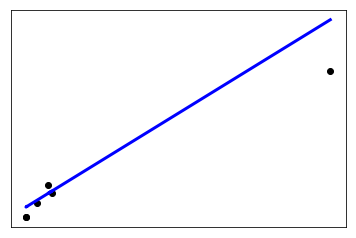

In [37]:
y_pred = reg.predict(X_test[col])

# Plot outputs
plt.scatter(X_test[col], y_test,  color='black')
plt.plot(X_test[col], y_pred, color='blue', linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

# Discussion

This looks like a nice linear relationship that we were able to
get out of this data after changing the representation of the data.
I think this is ready to scale up. We can show descriptively, examples
of the velocity converging to zero. We can forecast future convergence
by just using a linear regression. This seems pretty reasonable for
a class project.

In [49]:
reporting = pd.DataFrame([
    {"features": "all",
        "data": "test",
    "score": 0.8291107770270143},
    {"features": "all",
        "data": "val",
        "score": 0.9253225467308156},
    {"features": "authors",
    "data": "test",
    "score": 0.8103672820914342},
    {"features": "authors",
    "data": "val",
    "score": 0.8726493989475013}
])
reporting.score = reporting.score.apply(lambda x: round(x, 4))

reporting

,data,features,score
0,test,all,0.8291
1,val,all,0.9253
2,test,authors,0.8104
3,val,authors,0.8726
